In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf
from keras import metrics 


RANDOM_STATE = 2020
VAL_SPLIT = 0.2

# QUESTIONS

- How do I create a "baseline" (50% accuracy) neural network? (not an FSM, as is currently used)
    - Doesn't need to be a neural network. One model could be just predicting the most common class. Alternatively, randomly guessing 0 or 1
- After choosing final model based on top performance on validation data, should I then train the model on training *and* validation dataset together before testing on "Test" data?
    - Yes, run on combo of train and val
- What else is there to discuss in the Conclusion/Findings sections aside from performance metrics?
    - Describe the *why* this may be the best model (e.g. overly complex/overfitting)
    - Describe *why* the metric you used is the best metric. Also, what does this metric mean in terms of the business problem (x% FP, x% FN, etc.)
- After adding markdown commentary and code commentary, is this notebook comprehensive enough to be an MVP?
    - Consider adding more details on exploring data (shapes, etc.)
    - Any interesting facts at this stage? Perhaps there aren't any
    - Is there a clearly defined business problem, including the metrics that will be used.
    - As you go from one model to the other, mention why you decided to explore that way
    
- What images can I include in presentation? I understand Lime and SHAP can produce images, but that is only one type of image. We're supposed to include 3-5+. 
- Take a look at accuracy plots. Are these similar to what would be expected?

#### Select running platform for easy running on each platform:

In [2]:
PLATFORM = 'kaggle'

if PLATFORM == 'kaggle':
    path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'
    path_test  = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/'
    
elif PLATFORM == 'colab':
    path_train = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
    path_test  = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/test'
    from google.colab import drive
    drive.mount('/content/drive')
    
elif PLATFORM == 'local':
    path_train = '../data/raw/train'
    path_test  = '../data/raw/test'

else:
    sys.exit('ERROR: PLEASE ENTER "kaggle", "colab" or "local"')

### Import training data:

In [89]:
BATCH_SIZE = 1349+3883
TARGET_SIZE = 128


generator = ImageDataGenerator(rescale=1/255,)
gen_train = generator.flow_from_directory(directory=path_train, 
                                          target_size=(TARGET_SIZE, TARGET_SIZE), 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          seed=RANDOM_STATE)

train = next(gen_train)
images = train[0]
labels = train[1]
del gen_train, train # reduce memory usage

# Notes for future development
# Use small batch size and incorporate "generator" into the model fit()
# instead of importing all data to numpy array in memory

Found 5216 images belonging to 2 classes.


In [90]:
labels.sum(axis=0)

array([1341., 3875.], dtype=float32)

#### Define validation data *only* for testing model performance after fitting on 0.25 val split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x=images, y=labels, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size=VAL_SPLIT,
                                                  shuffle=True)
del images
del labels

In [5]:
def plot_metrics(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        metric=str.lower(metric)
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

#### Define callbacks

In [6]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25)]

### Define First Simple Model (FSM)

##### Uses only Dense layer

In [7]:
# Manually flatten Images array for input to Dense layer
shp = x_train.shape # temporary variable
x_train_flat = x_train.reshape(shp[0], 
                               shp[1]*shp[2]*shp[3])
shape = (x_train_flat.shape[1],)

# Manually flatten Images array for input to Dense layer
shp = x_val.shape # temporary variable
x_val_flat = x_val.reshape(shp[0], 
                             shp[1]*shp[2]*shp[3])
shape = (x_val_flat.shape[1],)

Epoch 1/5
131/131 [==============================] - 3s 14ms/step - loss: 16.9521 - accuracy: 0.6683 - recall: 0.6683 - precision: 0.6683 - val_loss: 8.0253 - val_accuracy: 0.7538 - val_recall: 0.7538 - val_precision: 0.7538
Epoch 2/5
131/131 [==============================] - 1s 8ms/step - loss: 3.8922 - accuracy: 0.8380 - recall: 0.8380 - precision: 0.8380 - val_loss: 3.5658 - val_accuracy: 0.8228 - val_recall: 0.8228 - val_precision: 0.8228
Epoch 3/5
131/131 [==============================] - 1s 8ms/step - loss: 2.9058 - accuracy: 0.8667 - recall: 0.8667 - precision: 0.8667 - val_loss: 0.6659 - val_accuracy: 0.9349 - val_recall: 0.9349 - val_precision: 0.9349
Epoch 4/5
131/131 [==============================] - 1s 7ms/step - loss: 1.2403 - accuracy: 0.9127 - recall: 0.9127 - precision: 0.9127 - val_loss: 2.6881 - val_accuracy: 0.8352 - val_recall: 0.8352 - val_precision: 0.8352
Epoch 5/5
33/33 [==============================] - 0s 6ms/step - loss: 3.1622 - accuracy: 0.8199 - recall:

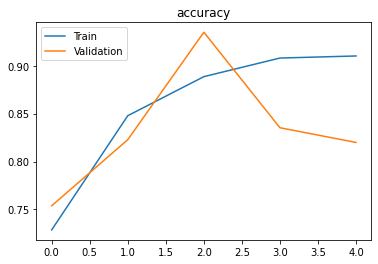

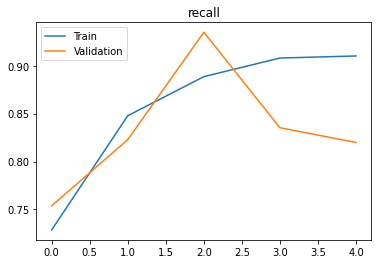

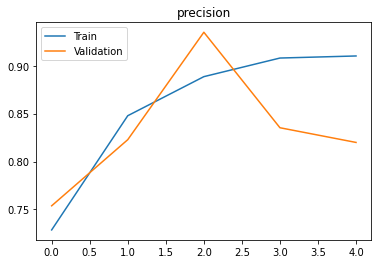

In [8]:
METRICS = ['accuracy', 'Recall', 'Precision']

model = Sequential()
model.add(Dense(2, activation='softmax', input_shape=shape))

model.compile(optimizer='SGD', 
              metrics=METRICS, 
              loss='categorical_crossentropy')


fit = model.fit(x=x_train_flat, 
                y=y_train, 
                epochs=5,
                validation_data=(x_val_flat, y_val),
                callbacks=callbacks,
                verbose=1)

# Create copy of object to be used on final test data comparison
fsm = model


plot_metrics(fit.history, metrics=METRICS)

print(model.evaluate(x_val_flat, y_val));
model.summary()
#del x_train_flat, x_val_flat

#### Add convolutional layer to previous model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      4736      
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1048578   
Total params: 1,053,314
Trainable params: 1,053,314
Non-trainable params: 0
_________________________________________________________________


None

33/33 [==============================] - 1s 20ms/step - loss: 0.1107 - accuracy: 0.9607


[0.11069899052381516, 0.9607279896736145]

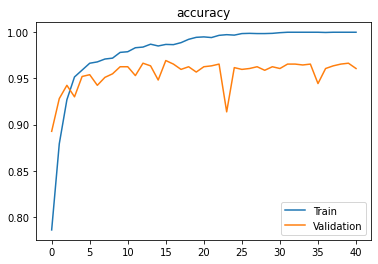

In [9]:
model = Sequential()
model.add(Conv2D(32,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Increase node count substantially

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 128)     86528     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4194306   
Total params: 4,280,834
Trainable params: 4,280,834
Non-trainable params: 0
_________________________________________________________________


None

33/33 [==============================] - 7s 202ms/step - loss: 0.1704 - accuracy: 0.9569


[0.17038613557815552, 0.9568965435028076]

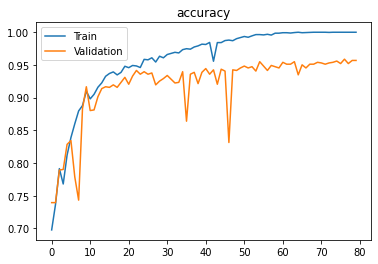

In [10]:
model = Sequential()
model.add(Conv2D(64,
                 kernel_size=11,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Instead, increase depth with pooling

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32770     
Total params: 40,242
Trainable params: 40,242
Non-trainable params: 0
__________________________________________________

None

33/33 [==============================] - 0s 12ms/step - loss: 0.0874 - accuracy: 0.9770


[0.08736387640237808, 0.977011501789093]

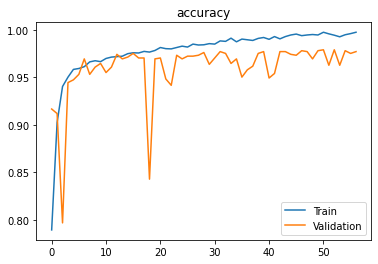

In [11]:
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16,
                 kernel_size=7,  
                 activation='relu',
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Add one more layer

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

None

33/33 [==============================] - 1s 18ms/step - loss: 0.1093 - accuracy: 0.9770


[0.10930634289979935, 0.977011501789093]

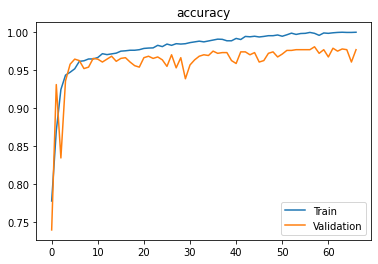

In [12]:
model = Sequential()
model.add(Conv2D(8,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16,
                 kernel_size=7,  
                 activation='relu',
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,
                 kernel_size=7,  
                 activation='relu',
                 padding='same'))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Add Regularization to top performing Convolutional

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        25120     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)             

None

33/33 [==============================] - 1s 16ms/step - loss: 0.1264 - accuracy: 0.9770


[0.12642726302146912, 0.977011501789093]

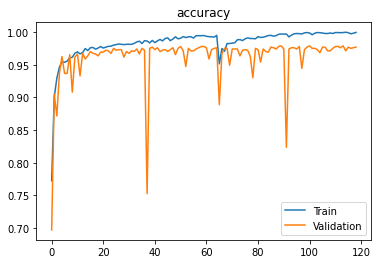

In [13]:
LAMBDA = 0.005


model = Sequential()
model.add(Conv2D(8,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16,
                 kernel_size=7,  
                 activation='relu',
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,
                 kernel_size=7,  
                 activation='relu',
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
          
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

#### Add Dropout to top Convolutional

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)       

None

33/33 [==============================] - 1s 17ms/step - loss: 0.0725 - accuracy: 0.9808


[0.07253469526767731, 0.9808428883552551]

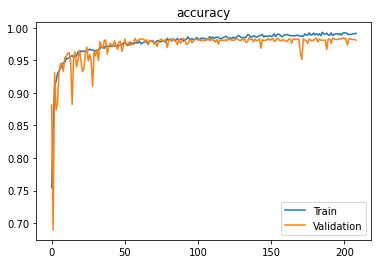

In [14]:
DROPOUT = 0.3
LAMBDA = 0.005


model = Sequential()
model.add(Conv2D(8,
                 kernel_size=7,  
                 input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                 activation='relu',
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(16,
                 kernel_size=7,  
                 activation='relu',
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Conv2D(32,
                 kernel_size=7,  
                 activation='relu',
                 padding='same',
                 kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(DROPOUT))

model.add(Flatten())

model.add(Dense(2, 
                activation='softmax'))

model.compile(optimizer='SGD',
              metrics=['accuracy'], 
              loss='categorical_crossentropy')

fit = model.fit(x=x_train, 
                y=y_train,
                epochs=500,
                callbacks=callbacks,
                validation_data=(x_val, y_val),
                verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(model.summary())


# Print evaluation results on validation set
model.evaluate(x_val, y_val)

In [16]:
# Having established the above model as the top performer, set it as "top_model" to be evaluated on Test data
top_model = model

#### Train top performing model on full training dataset (including "validation")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 8)       1184      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 16)        6288      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)       

None

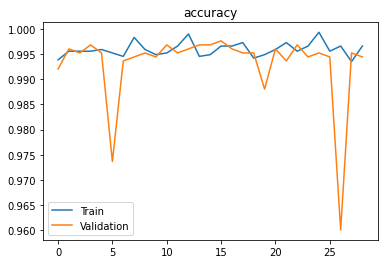

In [85]:
fit = top_model.fit(x=x_train, #np.concatenate([x_train, x_val], axis=0), 
                    y=y_train,#np.concatenate([y_train, y_val], axis=0),
                    epochs=500,
                    callbacks=callbacks,
                    validation_split=0.3,
                    verbose=0)

plot_metrics(fit.history)

#model.load_weights('best_model.h5')
display(top_model.summary())

# Delete training data to increase available memory, if necessary
# del x_train, y_train # clear memory if necessary
# del x_val, y_val # clear memory if necessary

## Measure performance on Test data

In [100]:
# Import Test data

BATCH_SIZE = 234+390

generator = ImageDataGenerator(rescale=1/255)
gen_test = generator.flow_from_directory(directory=path_test, 
                                          target_size=(TARGET_SIZE, TARGET_SIZE), 
                                          batch_size=BATCH_SIZE, 
                                          seed=RANDOM_STATE)

test = next(gen_test)
images_test = test[0]
labels_test = test[1]

del generator, gen_test, test # reduce memory usage

Found 624 images belonging to 2 classes.


In [101]:
# Print evaluation results on test set
top_model.evaluate(images_test, labels_test, verbose=1, return_dict=True)

20/20 [==============================] - 0s 17ms/step - loss: 1.2994 - accuracy: 0.7628


{'loss': 1.2994139194488525, 'accuracy': 0.7628205418586731}

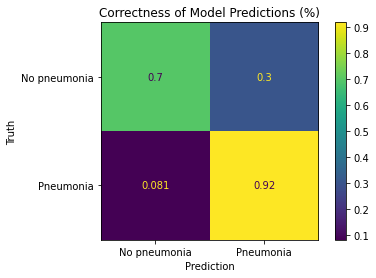

In [79]:
preds = top_model.predict(images_test)[:, 0].astype('int')
actual = labels_test[:, 0].astype('int')

matrix = confusion_matrix(preds, actual, normalize='true')
ConfusionMatrixDisplay(matrix).plot()
plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Correctness of Model Predictions (%)');

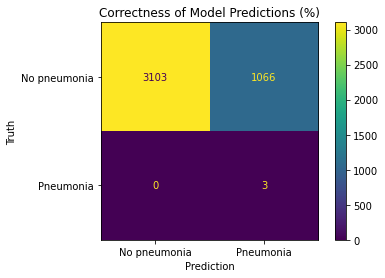

In [84]:
preds = top_model.predict(x_train)[:, 0].astype('int')
actual = y_train[:, 0].astype('int')

matrix = confusion_matrix(preds, actual)
ConfusionMatrixDisplay(matrix).plot()
plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Correctness of Model Predictions (%)');

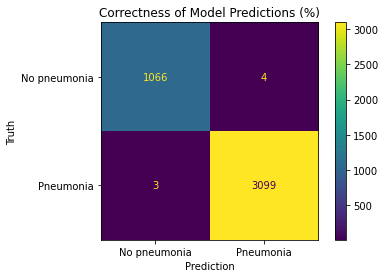

In [121]:
TRUTH = (y_train[:, 1]==1).astype('int')
PREDS = np.argmax(top_model.predict(x_train), axis=-1)

matrix = confusion_matrix(PREDS, TRUTH, normalize=None)
ConfusionMatrixDisplay(matrix).plot()
plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Correctness of Model Predictions (%)');

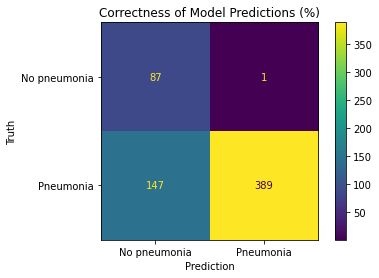

In [126]:
TRUTH = (labels_test[:, 1]==1).astype('int')
PREDS = np.argmax(top_model.predict(images_test), axis=-1)

matrix = confusion_matrix(PREDS, TRUTH)#, normalize='true')
ConfusionMatrixDisplay(matrix).plot()
plt.xticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.yticks(ticks = [0, 1], labels=['No pneumonia', 'Pneumonia'])
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.title('Correctness of Model Predictions (%)');